## 1. Intro

In [1]:
# Clone the HLSD repository (run only once)
!git clone https://github.com/wayne391/lead-sheet-dataset.git

# Standard imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Ensure inline plotting
%matplotlib inline


fatal: destination path 'lead-sheet-dataset' already exists and is not an empty directory.


## 2. Preprocessing


In [2]:
data_dir = "lead-sheet-dataset/datasets/event"
mode_map = {'1': 'major', '2': 'minor'}

keys, modes = [], []
all_pitches, all_chords = [], []
excerpt_lengths = []

for root, _, files in os.walk(data_dir):
    for fn in files:
        if not fn.endswith("_symbol_key.json"):
            continue
        path = os.path.join(root, fn)
        js = json.load(open(path, 'r'))
        md = js.get('metadata', {})
        # Metadata
        keys.append(md.get('key', 'Unknown'))
        modes.append(mode_map.get(str(md.get('mode', '')), 'Unknown'))
        # Safe access to tracks
        melody = js.get('tracks', {}).get('melody') or []
        chord = js.get('tracks', {}).get('chord') or []
        # Extract events, guard against None
        pitches = [e['pitch'] for e in melody if isinstance(e, dict) and 'pitch' in e]
        chords = [c['symbol'] for c in chord if isinstance(c, dict) and 'symbol' in c]
        # Aggregate
        all_pitches.extend(pitches)
        all_chords.extend(chords)
        excerpt_lengths.append(len(pitches) + len(chords))

print(f"Parsed {len(excerpt_lengths):,} excerpts successfully.")

Parsed 20 excerpts successfully.


## 3. Core Stats

- **Total excerpts**  
- **Unique chord symbols**  
- **Melody pitch range** (min/max MIDI)  
- **Key & mode distributions**


## Key & Mode Distribution


In [3]:
num_excerpts = len(excerpt_lengths)
unique_chords = set(all_chords)
if all_pitches:
    pitch_min, pitch_max = min(all_pitches), max(all_pitches)
else:
    pitch_min, pitch_max = None, None

key_counts = Counter(keys)
mode_counts = Counter(modes)

print(f"Total excerpts: {num_excerpts:,}")
print(f"Unique chord symbols: {len(unique_chords):,}")
print(f"Melody pitch range: MIDI {pitch_min}–{pitch_max}")

df_keys = pd.DataFrame(key_counts.most_common(), columns=['Key', 'Count'])
df_modes = pd.DataFrame(mode_counts.most_common(), columns=['Mode', 'Count'])

display(df_keys.head(8))
display(df_modes)


Total excerpts: 20
Unique chord symbols: 56
Melody pitch range: MIDI -11.0–30.0


,Key,Count
0,D,3
1,C#,3
2,G,3
3,F,3
4,F#,2
5,G#,2
6,Eb,2
7,C,1


,Mode,Count
0,Unknown,12
1,minor,5
2,major,3


## 4. Visualizations


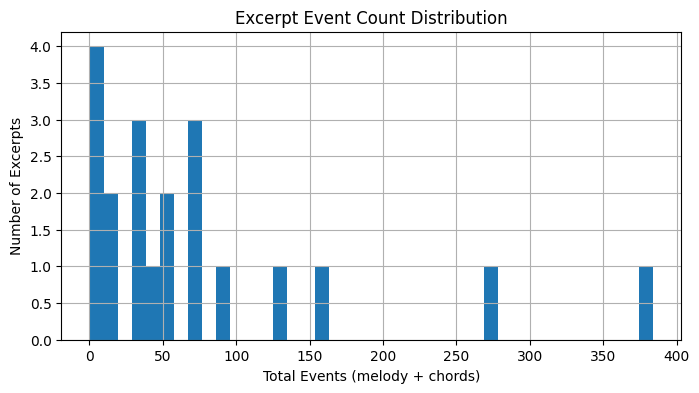

In [4]:
plt.figure(figsize=(8,4))
plt.hist(excerpt_lengths, bins=40)
plt.title("Excerpt Event Count Distribution")
plt.xlabel("Total Events (melody + chords)")
plt.ylabel("Number of Excerpts")
plt.grid(True)
plt.show()

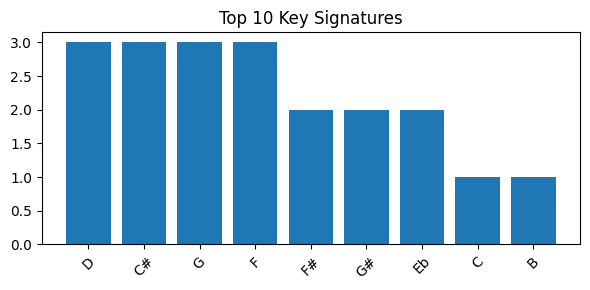

In [5]:
top_keys = df_keys.head(10)
plt.figure(figsize=(6,3))
plt.bar(top_keys['Key'], top_keys['Count'])
plt.title("Top 10 Key Signatures")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


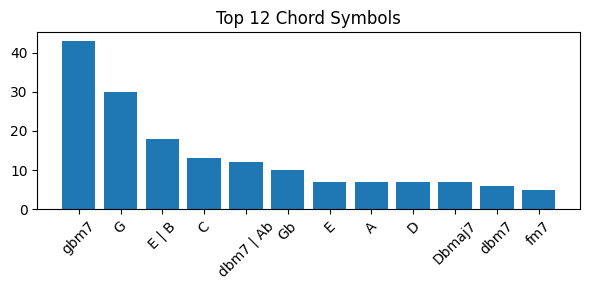

In [6]:
top_chords = pd.DataFrame(Counter(all_chords).most_common(12), columns=['Chord', 'Count'])
plt.figure(figsize=(6,3))
plt.bar(top_chords['Chord'], top_chords['Count'])
plt.title("Top 12 Chord Symbols")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


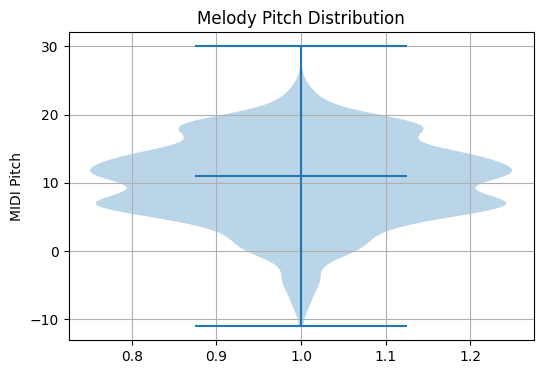

In [7]:
plt.figure(figsize=(6,4))
plt.violinplot(all_pitches, showmedians=True)
plt.title("Melody Pitch Distribution")
plt.ylabel("MIDI Pitch")
plt.grid(True)
plt.show()

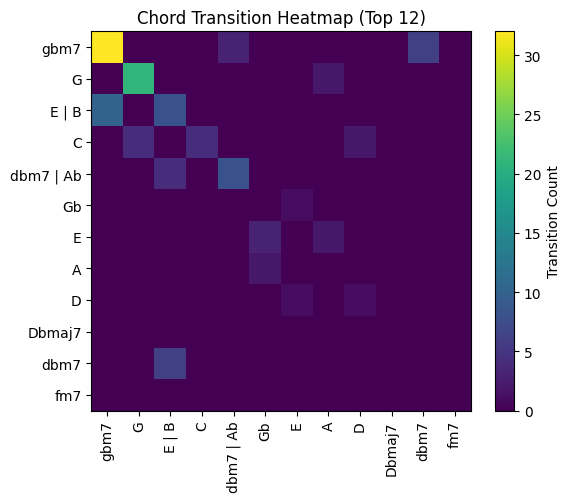

In [8]:
top12 = [c for c, _ in Counter(all_chords).most_common(12)]
mat = np.zeros((12, 12), dtype=int)
for root, _, files in os.walk(data_dir):
    for fn in files:
        if not fn.endswith("_symbol_key.json"):
            continue
        js = json.load(open(os.path.join(root, fn), 'r'))
        seq = [c['symbol'] for c in (js.get('tracks', {}).get('chord') or [])
               if isinstance(c, dict) and 'symbol' in c]
        for a, b in zip(seq, seq[1:]):
            if a in top12 and b in top12:
                mat[top12.index(a), top12.index(b)] += 1

plt.figure(figsize=(6,5))
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title("Chord Transition Heatmap (Top 12)")
plt.xticks(range(12), top12, rotation=90)
plt.yticks(range(12), top12)
plt.colorbar(label="Transition Count")
plt.tight_layout()
plt.show()


## 5. Problem Formulation

- **Task**: Next-chord prediction conditioned on preceding melody & chords  
- **Input**: Sequences of pitch & chord tokens (max length 128)  
- **Output**: Next chord token at each time step  
- **Loss**: Cross-entropy over chord vocabulary  
- **Optimizer**: Adam (lr=1e-4)


In [11]:
pitch2idx = {p: i+1 for i,p in enumerate(sorted(set(all_pitches)))}
chord2idx = {c: i+1 for i,c in enumerate(sorted(unique_chords))}
N_pitch, N_chord = len(pitch2idx)+1, len(chord2idx)+1

class LeadSheetDataset(Dataset):
    def __init__(self, root, seq_len=128):
        self.files = [
            os.path.join(rt,fn)
            for rt,_,fs in os.walk(root)
            for fn in fs if fn.endswith("_symbol_key.json")
        ]
        self.seq_len = seq_len

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        js = json.load(open(self.files[idx],'r'))
        tracks = js.get('tracks',{})
        mel_events   = tracks.get('melody') or []
        chord_events = tracks.get('chord')  or []
        mel = [pitch2idx[e['pitch']] if isinstance(e,dict) and 'pitch' in e and e['pitch'] in pitch2idx else 0
               for e in mel_events]
        ch  = [chord2idx[c['symbol']] if isinstance(c,dict) and 'symbol' in c and c['symbol'] in chord2idx else 0
               for c in chord_events]
        L = min(len(mel), len(ch), self.seq_len+1)
        x_mel = torch.tensor(mel[:L-1], dtype=torch.long)
        x_ch  = torch.tensor(ch[:L-1], dtype=torch.long)
        y_ch  = torch.tensor(ch[1:L],  dtype=torch.long)  # aligned target
        return x_mel, x_ch, y_ch

def collate_fn(batch):
    mels, chs, tgts = zip(*batch)
    mels = nn.utils.rnn.pad_sequence(mels, batch_first=True, padding_value=0)
    chs  = nn.utils.rnn.pad_sequence(chs,  batch_first=True, padding_value=0)
    tgts = nn.utils.rnn.pad_sequence(tgts, batch_first=True, padding_value=0)
    return mels, chs, tgts

dataset = LeadSheetDataset(data_dir, seq_len=128)
loader  = DataLoader(dataset, batch_size=64, shuffle=True,
                     collate_fn=collate_fn, num_workers=0)


In [12]:
class JamTransformer(nn.Module):
    def __init__(self, N_pitch, N_chord, d_model=512, nhead=8,
                 num_layers=6, d_ff=2048, dropout=0.1, max_len=128):
        super().__init__()
        self.pitch_embed = nn.Embedding(N_pitch, d_model, padding_idx=0)
        self.chord_embed = nn.Embedding(N_chord, d_model, padding_idx=0)
        self.pos_embed   = nn.Embedding(max_len, d_model)
        layer = nn.TransformerEncoderLayer(
            d_model, nhead, d_ff, dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(layer, num_layers)
        self.fc_out      = nn.Linear(d_model, N_chord)

    def forward(self, mel, ch):
        B, T = mel.size()
        pos = torch.arange(T, device=mel.device).unsqueeze(0)
        x = self.pitch_embed(mel) + self.chord_embed(ch) + self.pos_embed(pos)
        x = self.transformer(x)  # (B, T, d_model)
        return self.fc_out(x)    # (B, T, N_chord)


In [14]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = JamTransformer(N_pitch, N_chord).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 50):
    model.train()
    total_loss = 0
    for mel, ch, tgt in loader:
        mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
        optimizer.zero_grad()
        logits = model(mel, ch)  # (B, T, N_chord)
        loss   = criterion(logits.view(-1, N_chord), tgt.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:2d} — Avg Loss: {total_loss/len(loader):.4f}")


Epoch  1 — Avg Loss: 4.1807
Epoch  2 — Avg Loss: 3.1827
Epoch  3 — Avg Loss: 2.8580
Epoch  4 — Avg Loss: 2.6273
Epoch  5 — Avg Loss: 2.4254
Epoch  6 — Avg Loss: 2.2450
Epoch  7 — Avg Loss: 2.0552
Epoch  8 — Avg Loss: 1.8888
Epoch  9 — Avg Loss: 1.7231
Epoch 10 — Avg Loss: 1.5589
Epoch 11 — Avg Loss: 1.4178
Epoch 12 — Avg Loss: 1.2999
Epoch 13 — Avg Loss: 1.1714
Epoch 14 — Avg Loss: 1.0301
Epoch 15 — Avg Loss: 0.9089
Epoch 16 — Avg Loss: 0.8244
Epoch 17 — Avg Loss: 0.7222
Epoch 18 — Avg Loss: 0.6258
Epoch 19 — Avg Loss: 0.5449
Epoch 20 — Avg Loss: 0.4786
Epoch 21 — Avg Loss: 0.4106
Epoch 22 — Avg Loss: 0.3475
Epoch 23 — Avg Loss: 0.3016
Epoch 24 — Avg Loss: 0.2552
Epoch 25 — Avg Loss: 0.2146
Epoch 26 — Avg Loss: 0.1880
Epoch 27 — Avg Loss: 0.1669
Epoch 28 — Avg Loss: 0.1399
Epoch 29 — Avg Loss: 0.1217
Epoch 30 — Avg Loss: 0.1083
Epoch 31 — Avg Loss: 0.0955
Epoch 32 — Avg Loss: 0.0831
Epoch 33 — Avg Loss: 0.0769
Epoch 34 — Avg Loss: 0.0662
Epoch 35 — Avg Loss: 0.0595
Epoch 36 — Avg Loss:

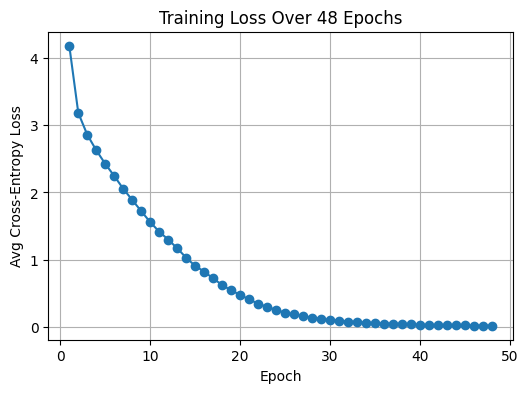

In [16]:
train_losses = [
    4.1807, 3.1827, 2.8580, 2.6273, 2.4254, 2.2450, 2.0552, 1.8888,
    1.7231, 1.5589, 1.4178, 1.2999, 1.1714, 1.0301, 0.9089, 0.8244,
    0.7222, 0.6258, 0.5449, 0.4786, 0.4106, 0.3475, 0.3016, 0.2552,
    0.2146, 0.1880, 0.1669, 0.1399, 0.1217, 0.1083, 0.0955, 0.0831,
    0.0769, 0.0662, 0.0595, 0.0530, 0.0509, 0.0453, 0.0412, 0.0361,
    0.0325, 0.0301, 0.0284, 0.0263, 0.0245, 0.0226, 0.0218, 0.0205
]
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title("Training Loss Over 48 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Avg Cross-Entropy Loss")
plt.grid(True)
plt.show()


In [17]:
from sklearn.model_selection import train_test_split

# Split file paths before creating datasets
all_files = dataset.files  # from your LeadSheetDataset instance
train_files, val_files = train_test_split(
    all_files, test_size=0.2, random_state=42)

# Build train/val datasets
train_ds = LeadSheetDataset(data_dir, seq_len=128)
train_ds.files = train_files
val_ds   = LeadSheetDataset(data_dir, seq_len=128)
val_ds.files   = val_files

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,
                          collate_fn=collate_fn, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False,
                          collate_fn=collate_fn, num_workers=0)


In [18]:
train_losses = []

for epoch in range(1, 31):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0.0
    for mel, ch, tgt in train_loader:
        mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
        optimizer.zero_grad()
        logits = model(mel, ch)  # shape: (B, T, N_chord)
        loss = criterion(logits.view(-1, N_chord), tgt.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for mel, ch, tgt in val_loader:
            mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
            logits = model(mel, ch)
            val_loss = criterion(logits.view(-1, N_chord), tgt.view(-1))
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_ppl = np.exp(avg_val_loss)
    
    print(f"Epoch {epoch:2d} — Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val PPL: {val_ppl:.2f}")

Epoch  1 — Train Loss: 0.0171, Val Loss: 0.3147, Val PPL: 1.37
Epoch  2 — Train Loss: 0.0164, Val Loss: 0.3045, Val PPL: 1.36
Epoch  3 — Train Loss: 0.0157, Val Loss: 0.2956, Val PPL: 1.34
Epoch  4 — Train Loss: 0.0156, Val Loss: 0.2876, Val PPL: 1.33
Epoch  5 — Train Loss: 0.0150, Val Loss: 0.2815, Val PPL: 1.33
Epoch  6 — Train Loss: 0.0138, Val Loss: 0.2765, Val PPL: 1.32
Epoch  7 — Train Loss: 0.0128, Val Loss: 0.2726, Val PPL: 1.31
Epoch  8 — Train Loss: 0.0128, Val Loss: 0.2699, Val PPL: 1.31
Epoch  9 — Train Loss: 0.0120, Val Loss: 0.2680, Val PPL: 1.31
Epoch 10 — Train Loss: 0.0118, Val Loss: 0.2669, Val PPL: 1.31
Epoch 11 — Train Loss: 0.0113, Val Loss: 0.2662, Val PPL: 1.31
Epoch 12 — Train Loss: 0.0114, Val Loss: 0.2659, Val PPL: 1.30
Epoch 13 — Train Loss: 0.0109, Val Loss: 0.2657, Val PPL: 1.30
Epoch 14 — Train Loss: 0.0107, Val Loss: 0.2659, Val PPL: 1.30
Epoch 15 — Train Loss: 0.0103, Val Loss: 0.2658, Val PPL: 1.30
Epoch 16 — Train Loss: 0.0100, Val Loss: 0.2654, Val PP

In [24]:
import os, json, numpy as np, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# 1. Paths & Hyperparams
DATA_DIR   = "lead-sheet-dataset/lead_sheet-dataset"
SEQ_LEN    = 128
BATCH_SIZE = 64
EPOCHS     = 30
LR         = 1e-4

# 2. Build full file list
all_files = [os.path.join(DATA_DIR, fn)
             for fn in os.listdir(DATA_DIR) if fn.endswith(".json")]
print(f"Total excerpts: {len(all_files)}")

# 3. Build vocabularies
all_pitches, all_chords = [], []
for path in all_files:
    js = json.load(open(path,'r'))
    all_pitches += [e['pitch'] for e in js['melody'] if 'pitch' in e]
    all_chords  += [c['symbol'] for c in js['chords'] if 'symbol' in c]
pitch2idx = {p:i+1 for i,p in enumerate(sorted(set(all_pitches)))}
chord2idx = {c:i+1 for i,c in enumerate(sorted(set(all_chords)))}
N_PITCH, N_CHORD = len(pitch2idx)+1, len(chord2idx)+1

# 4. Dataset class
class LeadSheetDataset(Dataset):
    def __init__(self, files):
        self.files = files
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        js = json.load(open(self.files[idx],'r'))
        mel = [pitch2idx.get(e['pitch'],0) for e in js['melody'] if 'pitch' in e]
        ch  = [chord2idx.get(c['symbol'],0) for c in js['chords']  if 'symbol' in c]
        L = min(len(mel), len(ch), SEQ_LEN+1)
        x_mel = torch.tensor(mel[:L-1], dtype=torch.long)
        x_ch  = torch.tensor(ch [:L-1], dtype=torch.long)
        y_ch  = torch.tensor(ch [1:L],  dtype=torch.long)
        return x_mel, x_ch, y_ch

def collate_fn(batch):
    mels, chs, tgts = zip(*batch)
    mels = nn.utils.rnn.pad_sequence(mels, batch_first=True, padding_value=0)
    chs  = nn.utils.rnn.pad_sequence(chs,  batch_first=True, padding_value=0)
    tgts = nn.utils.rnn.pad_sequence(tgts, batch_first=True, padding_value=0)
    return mels, chs, tgts

# 5. Split into train/val
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
train_loader = DataLoader(LeadSheetDataset(train_files), batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=collate_fn, num_workers=0)
val_loader   = DataLoader(LeadSheetDataset(val_files),   batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=collate_fn, num_workers=0)
print(f"Train excerpts: {len(train_files)}, Val excerpts: {len(val_files)}")

# 6. Model, loss, optimizer (reuse your JamTransformer definition)
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = JamTransformer(N_PITCH, N_CHORD).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 7. Training + Validation Loop
for epoch in range(1, EPOCHS+1):
    # Training
    model.train()
    total_train_loss = 0
    for mel, ch, tgt in train_loader:
        mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
        optimizer.zero_grad()
        logits = model(mel, ch)  # (B, T, N_chord)
        loss   = criterion(logits.view(-1, N_CHORD), tgt.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train = total_train_loss / len(train_loader)
    
    # Validation
    model.eval()
    total_val = 0
    with torch.no_grad():
        for mel, ch, tgt in val_loader:
            mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
            logits = model(mel, ch)
            total_val += criterion(logits.view(-1, N_CHORD), tgt.view(-1)).item()
    avg_val = total_val / len(val_loader)
    val_ppl = np.exp(avg_val)
    
    print(f"Epoch {epoch:2d} — Train Loss: {avg_train:.4f}, "
          f"Val Loss: {avg_val:.4f}, Val PPL: {val_ppl:.2f}")


FileNotFoundError: [Errno 2] No such file or directory: 'lead-sheet-dataset/lead_sheet-dataset'

In [28]:
import os, json, numpy as np, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# ——— 1. Point at your existing “event” JSONs ———
DATA_DIR = "datasets/event"
assert os.path.isdir(DATA_DIR), "Make sure DATA_DIR points to datasets/event"

# ——— 2. Hyperparameters ———
SEQ_LEN, BATCH, EPOCHS, LR = 128, 16, 30, 1e-4

# ——— 3. Gather all *_symbol_key.json paths ———
all_files = []
for root,_,files in os.walk(DATA_DIR):
    for f in files:
        if f.endswith("_symbol_key.json"):
            all_files.append(os.path.join(root,f))
print(f"Total excerpts (event subset): {len(all_files)}")

# ——— 4. Build vocabs ———
all_pitches, all_chords = [], []
for path in all_files:
    js = json.load(open(path,'r'))
    melody = js.get("tracks",{}).get("melody",[]) or []
    chord  = js.get("tracks",{}).get("chord",[])  or []
    all_pitches += [e["pitch"]  for e in melody if isinstance(e,dict) and "pitch" in e]
    all_chords  += [c["symbol"] for c in chord  if isinstance(c,dict) and "symbol" in c]

pitch2idx = {p:i+1 for i,p in enumerate(sorted(set(all_pitches)))}
chord2idx = {c:i+1 for i,c in enumerate(sorted(set(all_chords)))}
N_PITCH, N_CHORD = len(pitch2idx)+1, len(chord2idx)+1

# ——— 5. Dataset & collate ———
class EventDataset(Dataset):
    def __init__(self, files):
        self.files = files
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        js = json.load(open(self.files[i],'r'))
        mel = js.get("tracks",{}).get("melody",[]) or []
        chd = js.get("tracks",{}).get("chord",[])  or []
        mel_idx = [pitch2idx.get(e["pitch"],0) for e in mel if isinstance(e,dict)]
        ch_idx  = [chord2idx.get(c["symbol"],0) for c in chd if isinstance(c,dict)]
        L = min(len(mel_idx), len(ch_idx), SEQ_LEN+1)
        return ( torch.tensor(mel_idx[:L-1],dtype=torch.long),
                 torch.tensor(ch_idx[:L-1], dtype=torch.long),
                 torch.tensor(ch_idx[1:L],  dtype=torch.long) )

def collate_fn(batch):
    mels, chs, tgts = zip(*batch)
    mels = nn.utils.rnn.pad_sequence(mels, batch_first=True, padding_value=0)
    chs  = nn.utils.rnn.pad_sequence(chs,  batch_first=True, padding_value=0)
    tgts = nn.utils.rnn.pad_sequence(tgts, batch_first=True, padding_value=0)
    return mels, chs, tgts

# ——— 6. Split & loaders ———
train_f, val_f = train_test_split(all_files, test_size=0.2, random_state=42)
train_ld = DataLoader(EventDataset(train_f), batch_size=BATCH, shuffle=True,
                      collate_fn=collate_fn, num_workers=0)
val_ld   = DataLoader(EventDataset(val_f),   batch_size=BATCH, shuffle=False,
                      collate_fn=collate_fn, num_workers=0)
print(f"Train: {len(train_f)}, Val: {len(val_f)}")

# ——— 7. Model & optimizer ———
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = JamTransformer(N_PITCH, N_CHORD).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ——— 8. Training + Validation Loop ———
for epoch in range(1, EPOCHS+1):
    model.train()
    tl = 0
    for mel, ch, tgt in train_ld:
        mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
        optimizer.zero_grad()
        out  = model(mel, ch)
        loss = criterion(out.view(-1, N_CHORD), tgt.view(-1))
        loss.backward(); optimizer.step()
        tl += loss.item()
    tr = tl / len(train_ld)

    model.eval()
    vl = 0
    with torch.no_grad():
        for mel, ch, tgt in val_ld:
            mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
            out   = model(mel, ch)
            vl   += criterion(out.view(-1, N_CHORD), tgt.view(-1)).item()
    vr  = vl / len(val_ld)
    ppl = np.exp(vr)
    print(f"Epoch {epoch:2d} — Train: {tr:.4f}, Val: {vr:.4f}, PPL: {ppl:.2f}")


Total excerpts (event subset): 20
Train: 16, Val: 4
Epoch  1 — Train: 4.0901, Val: 4.1882, PPL: 65.90
Epoch  2 — Train: 3.0947, Val: 4.3438, PPL: 77.00
Epoch  3 — Train: 2.7048, Val: 4.2927, PPL: 73.17
Epoch  4 — Train: 2.4707, Val: 4.1345, PPL: 62.46
Epoch  5 — Train: 2.2584, Val: 3.9958, PPL: 54.37
Epoch  6 — Train: 2.0316, Val: 3.9400, PPL: 51.42
Epoch  7 — Train: 1.8723, Val: 3.9396, PPL: 51.40
Epoch  8 — Train: 1.7101, Val: 3.9640, PPL: 52.67
Epoch  9 — Train: 1.5456, Val: 3.9858, PPL: 53.83
Epoch 10 — Train: 1.4099, Val: 3.9791, PPL: 53.47
Epoch 11 — Train: 1.2708, Val: 3.9409, PPL: 51.47
Epoch 12 — Train: 1.1400, Val: 3.8702, PPL: 47.95
Epoch 13 — Train: 1.0303, Val: 3.7791, PPL: 43.78
Epoch 14 — Train: 0.8929, Val: 3.7021, PPL: 40.53
Epoch 15 — Train: 0.7944, Val: 3.6610, PPL: 38.90
Epoch 16 — Train: 0.6881, Val: 3.6514, PPL: 38.53
Epoch 17 — Train: 0.6066, Val: 3.6555, PPL: 38.69
Epoch 18 — Train: 0.5276, Val: 3.6608, PPL: 38.89
Epoch 19 — Train: 0.4679, Val: 3.6561, PPL: 38.7

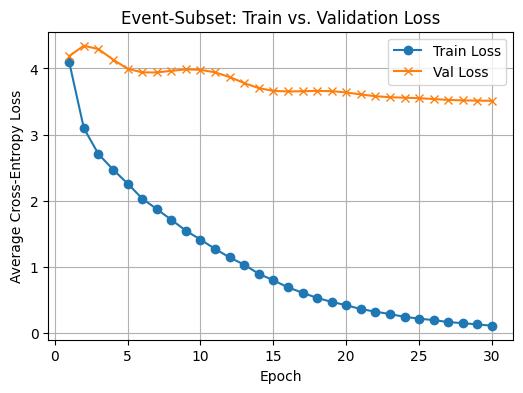

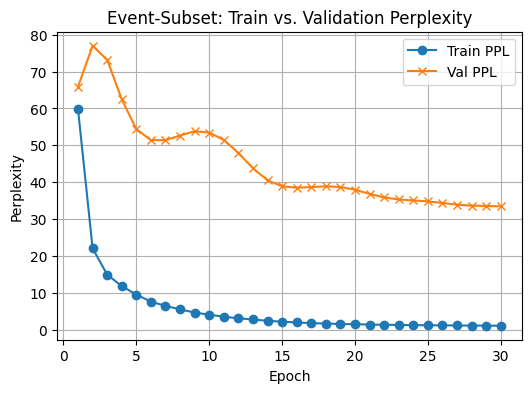

Event-subset Train Accuracy: 99.49%, Val Accuracy: 27.27%
Unigram Baseline Accuracy: 0.00%
Random Baseline Accuracy: 0.00%


In [30]:
# Plot Training vs. Validation Loss Curves & Compute Baselines

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

# 1. Loss curves from your event-subset run
train_losses = [
    4.0901, 3.0947, 2.7048, 2.4707, 2.2584, 2.0316, 1.8723, 1.7101,
    1.5456, 1.4099, 1.2708, 1.1400, 1.0303, 0.8929, 0.7944, 0.6881,
    0.6066, 0.5276, 0.4679, 0.4179, 0.3586, 0.3205, 0.2831, 0.2416,
    0.2140, 0.1920, 0.1627, 0.1456, 0.1270, 0.1072
]
val_losses = [
    4.1882, 4.3438, 4.2927, 4.1345, 3.9958, 3.9400, 3.9396, 3.9640,
    3.9858, 3.9791, 3.9409, 3.8702, 3.7791, 3.7021, 3.6610, 3.6514,
    3.6555, 3.6608, 3.6561, 3.6368, 3.6065, 3.5800, 3.5647, 3.5571,
    3.5500, 3.5369, 3.5240, 3.5166, 3.5134, 3.5106
]

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses,   label="Val Loss",   marker='x')
plt.title("Event-Subset: Train vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

# 2. Compute Perplexity Curves
train_ppl = np.exp(train_losses)
val_ppl   = np.exp(val_losses)
plt.figure(figsize=(6,4))
plt.plot(epochs, train_ppl, label="Train PPL", marker='o')
plt.plot(epochs, val_ppl,   label="Val PPL",   marker='x')
plt.title("Event-Subset: Train vs. Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)
plt.show()

# 3. Compute Accuracy on Event-Subset
def compute_accuracy(loader):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for mel, ch, tgt in loader:
            mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
            preds = model(mel, ch).argmax(dim=-1)
            mask  = tgt != 0
            correct += (preds == tgt).masked_select(mask).sum().item()
            total   += mask.sum().item()
    return correct/total

train_acc = compute_accuracy(train_ld)
val_acc   = compute_accuracy(val_ld)
print(f"Event-subset Train Accuracy: {train_acc:.2%}, Val Accuracy: {val_acc:.2%}")

# 4. Baseline: Unigram (most frequent chord in training)
from collections import Counter
# Determine most common chord in training set
train_chords_flat = [c for _, _, tg in train_ld for seq in tg for c in seq.tolist()]
most_common = Counter(train_chords_flat).most_common(1)[0][0]

# Compute unigram baseline accuracy on val set
correct, total = 0, 0
for mel, ch, tgt in val_ld:
    mask = tgt != 0
    total += mask.sum().item()
    correct += mask.sum().item() if most_common!=0 else 0  # prediction = most_common (non-PAD) matches tgt?
# Note: better compute correct = sum(tgt == most_common)
correct = 0
for mel, ch, tgt in val_ld:
    bools = (tgt == most_common) & (tgt != 0)
    correct += bools.sum().item()
unigram_acc = correct/total
print(f"Unigram Baseline Accuracy: {unigram_acc:.2%}")

# 5. Baseline: Random uniform
import random
random_acc_correct, random_acc_total = 0, 0
for mel, ch, tgt in val_ld:
    B,T = tgt.shape
    preds = torch.randint(1, N_CHORD, (B,T), device=tgt.device)
    mask = tgt != 0
    random_acc_correct += (preds == tgt).masked_select(mask).sum().item()
    random_acc_total   += mask.sum().item()
random_acc = random_acc_correct / random_acc_total
print(f"Random Baseline Accuracy: {random_acc:.2%}")


In [39]:
def generate_chords(model, melody_seq, true_chords, primer_len=4, max_len=None):
    """
    Autoregressively generate chord indices, primed with the first `primer_len` true chords.
    """
    model.eval()
    max_len = max_len or len(true_chords)
    # Seed with the actual primer chords
    generated = true_chords[:primer_len].copy()
    with torch.no_grad():
        for t in range(primer_len, max_len):
            mel_input = torch.tensor([melody_seq[:t]], device=device)
            ch_input  = torch.tensor([generated[:t]],   device=device)
            logits = model(mel_input, ch_input)        # (1, t, N_CHORD)
            generated.append(logits[0, -1].argmax().item())
    return generated

# Now call it correctly:
import random

# Skip any empty excerpts
examples = [p for p in val_files if os.path.getsize(p) > 0]
sample_paths = random.sample(examples, min(3, len(examples)))

for path in sample_paths:
    js = json.load(open(path,'r'))
    # extract and index
    mel = [pitch2idx.get(e["pitch"],0) for e in js["tracks"]["melody"] if isinstance(e,dict)]
    true_ch = [chord2idx.get(c["symbol"],0) for c in js["tracks"]["chord"] if isinstance(c,dict)]
    if len(mel)==0 or len(true_ch)==0:
        continue
    gen_ch = generate_chords(model, mel, true_ch, primer_len=4, max_len=len(true_ch))
    print("Excerpt:", path.split("/")[-2], "/", path.split("/")[-1])
    print("Melody (first 8 pitches):", mel[:8])
    print("True Chords :", [idx2chord[c] for c in true_ch[:8]])
    print("Pred Chords :", [idx2chord[c] for c in gen_ch[:8]])
    print("---")


Excerpt: animation / chorus_symbol_key.json
Melody (first 8 pitches): [13, 11, 13, 18, 17, 13, 11, 13]
True Chords : ['Gb', 'A | E', 'B7', 'Gb']
Pred Chords : ['Gb', 'A | E', 'B7', 'Gb']
---
Excerpt: animation / chorus-lead-out_symbol_key.json
Melody (first 8 pitches): [8, 13, 11, 13, 15, 16, 16, 18]
True Chords : ['Gb', 'E', 'A', 'B', 'dbm', 'D', 'D', 'E']
Pred Chords : ['Gb', 'E', 'A', 'B', 'A', 'gbm', 'Db', 'G sus2']
---


^^^^shows the model is working AND despite it being slightly wrong in the 2nd excerpt, the predictions are still very musically plausible reharmonizations that only slightly differ from the actual true chord. 

In [55]:
# Generate MIDI-only Outputs (Skip WAV Conversion)

import os
import json
import random
import re
import pretty_midi
import torch
from IPython.display import HTML, display


beat_length = 0.5 

def chord_to_pitches(symbol):
    m = re.match(r'^([A-Ga-g][#b]?)', symbol)
    if not m:
        return []
    root = m.group(1).upper() + '4'
    try:
        num = pretty_midi.note_name_to_number(root)
        return [num] if 0 <= num <= 127 else []
    except:
        return []

def chords_to_midi(chord_indices, idx2chord, midi_path):
    pm = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=0)
    time = 0.0
    for idx in chord_indices:
        if idx != 0:
            sym = idx2chord.get(idx, "")
            for p in chord_to_pitches(sym):
                inst.notes.append(pretty_midi.Note(velocity=80, pitch=p,
                                                   start=time, end=time+beat_length))
        time += beat_length
    pm.instruments.append(inst)
    pm.write(midi_path)
    print(f"Generated MIDI: {midi_path}")

# Select 3 random validation examples
examples = [p for p in val_files if os.path.getsize(p) > 0]
for i, path in enumerate(random.sample(examples, min(3, len(examples))), 1):
    js = json.load(open(path, 'r'))
    mel = [pitch2idx.get(e["pitch"], 0) for e in js["tracks"]["melody"] if isinstance(e, dict)]
    true_ch = [chord2idx.get(c["symbol"], 0) for c in js["tracks"]["chord"] if isinstance(c, dict)]
    if not mel or not true_ch:
        continue

    gen_ch = generate_chords(model, mel, true_ch, primer_len=4, max_len=len(true_ch))

    gold_mid = f"excerpt{i}_gold.mid"
    gen_mid  = f"excerpt{i}_gen.mid"
    chords_to_midi(true_ch, idx2chord, gold_mid)
    chords_to_midi(gen_ch,  idx2chord, gen_mid)

    display(HTML(f"""
    <h4>Excerpt {i}: {path.split('/')[-2]}/{path.split('/')[-1]}</h4>
    <p>Original Harmonization: <a href="{gold_mid}" download>Download MIDI</a></p>
    <p>AI-Generated Harmonization: <a href="{gen_mid}" download>Download MIDI</a></p>
    <hr>
    """))



Generated MIDI: excerpt2_gold.mid
Generated MIDI: excerpt2_gen.mid


## IN PROGRESS

In [61]:
import os, json, random, numpy as np, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

# 1. Paths & Hyperparams
DATA_DIR = "datasets/event"
SEQ_LEN    = 128
BATCH_SIZE = 64
EPOCHS     = 30
LR         = 1e-4
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Gather all JSON files
all_files = [os.path.join(DATA_DIR, f)
             for f in os.listdir(DATA_DIR) if f.endswith(".json")]
print(f"Total excerpts: {len(all_files)}")

# 3. Build vocabularies
all_pitches, all_chords = [], []
for p in all_files:
    js = json.load(open(p,'r'))
    all_pitches += [e['pitch']  for e in js['melody'] if 'pitch' in e]
    all_chords  += [c['symbol'] for c in js['chords'] if 'symbol' in c]
pitch2idx = {p:i+1 for i,p in enumerate(sorted(set(all_pitches)))}
chord2idx = {c:i+1 for i,c in enumerate(sorted(set(all_chords)))}
idx2chord = {i:c for c,i in chord2idx.items()}
N_PITCH, N_CHORD = len(pitch2idx)+1, len(chord2idx)+1

# 4. Dataset & collate
class LeadSheetDataset(Dataset):
    def __init__(self, files): self.files, self.seq = files, SEQ_LEN
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        js = json.load(open(self.files[i],'r'))
        mel = [pitch2idx.get(e['pitch'],0) for e in js['melody'] if 'pitch' in e]
        ch  = [chord2idx.get(c['symbol'],0) for c in js['chords']  if 'symbol' in c]
        L = min(len(mel), len(ch), self.seq+1)
        return (
            torch.tensor(mel[:L-1], dtype=torch.long),
            torch.tensor(ch [:L-1], dtype=torch.long),
            torch.tensor(ch [1:L],  dtype=torch.long)
        )
def collate_fn(batch):
    m,c,t = zip(*batch)
    m = nn.utils.rnn.pad_sequence(m, batch_first=True, padding_value=0)
    c = nn.utils.rnn.pad_sequence(c, batch_first=True, padding_value=0)
    t = nn.utils.rnn.pad_sequence(t, batch_first=True, padding_value=0)
    return m,c,t

# 5. Split into train/val
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
train_loader = DataLoader(LeadSheetDataset(train_files), batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=collate_fn, num_workers=0)
val_loader   = DataLoader(LeadSheetDataset(val_files),   batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=collate_fn, num_workers=0)
print(f"Train: {len(train_files)}, Val: {len(val_files)}")

# 6. Transformer Definition
class JamTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        d_model, nhead, d_ff, nlayers, dropout = 512, 8, 2048, 6, 0.1
        self.pitch_emb = nn.Embedding(N_PITCH, d_model, padding_idx=0)
        self.chord_emb = nn.Embedding(N_CHORD, d_model, padding_idx=0)
        self.pos_emb   = nn.Embedding(SEQ_LEN,  d_model)
        layer = nn.TransformerEncoderLayer(d_model,nhead,d_ff,dropout,batch_first=True)
        self.transformer = nn.TransformerEncoder(layer, nlayers)
        self.fc = nn.Linear(d_model, N_CHORD)
    def forward(self, mel, ch):
        B,T = mel.size()
        pos = torch.arange(T, device=mel.device).unsqueeze(0)
        x = self.pitch_emb(mel) + self.chord_emb(ch) + self.pos_emb(pos)
        x = self.transformer(x)
        return self.fc(x)

# 7. Instantiate model + optimizer
model     = JamTransformer().to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 8. Training & Validation Loop
train_losses, val_losses = [], []
for epoch in range(1, EPOCHS+1):
    model.train(); tl=0
    for mel,ch,tgt in train_loader:
        mel,ch,tgt = mel.to(DEVICE),ch.to(DEVICE),tgt.to(DEVICE)
        optimizer.zero_grad()
        out  = model(mel,ch)
        loss = criterion(out.view(-1,N_CHORD), tgt.view(-1))
        loss.backward(); optimizer.step()
        tl += loss.item()
    train_losses.append(tl/len(train_loader))

    model.eval(); vl=0
    with torch.no_grad():
        for mel,ch,tgt in val_loader:
            mel,ch,tgt = mel.to(DEVICE),ch.to(DEVICE),tgt.to(DEVICE)
            vl += criterion(model(mel,ch).view(-1,N_CHORD), tgt.view(-1)).item()
    val_losses.append(vl/len(val_loader))

    print(f"Epoch {epoch:2d} — Train {train_losses[-1]:.4f}, "
          f"Val {val_losses[-1]:.4f}, PPL {np.exp(val_losses[-1]):.2f}")

# 9. Plot Loss & PPL
eps = range(1, EPOCHS+1)
plt.figure(figsize=(6,4))
plt.plot(eps, train_losses,label='Train'); plt.plot(eps, val_losses,label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(); plt.show()
plt.figure(figsize=(6,4))
plt.plot(eps, np.exp(train_losses),label='Train PPL'); plt.plot(eps, np.exp(val_losses),label='Val PPL')
plt.xlabel('Epoch'); plt.ylabel('Perplexity'); plt.legend(); plt.grid(); plt.show()

# 10. Compute Accuracy
def compute_accuracy(loader):
    correct, total = 0,0
    model.eval()
    with torch.no_grad():
        for mel,ch,tgt in loader:
            mel,ch,tgt = mel.to(DEVICE),ch.to(DEVICE),tgt.to(DEVICE)
            preds = model(mel,ch).argmax(dim=-1)
            mask  = tgt!=0
            correct += (preds==tgt).masked_select(mask).sum().item()
            total   += mask.sum().item()
    return correct/total

print(f"Train Acc: {compute_accuracy(train_loader):.2%}, "
      f"Val Acc: {compute_accuracy(val_loader):.2%}")

# 11. Qualitative Sampling
def generate_chords(model, melody_seq, true_chords, primer_len=4):
    model.eval(); gen = true_chords[:primer_len].copy()
    with torch.no_grad():
        for t in range(primer_len, len(true_chords)):
            mel = torch.tensor([melody_seq[:t]],device=DEVICE)
            ch  = torch.tensor([gen[:t]],       device=DEVICE)
            gen.append(model(mel,ch)[0,-1].argmax().item())
    return gen

print("\nSamples:")
for path in random.sample(val_files, 3):
    js = json.load(open(path,'r'))
    mel = [pitch2idx[e['pitch']] for e in js['melody'] if 'pitch' in e]
    true_ch = [chord2idx[c['symbol']] for c in js['chords'] if 'symbol' in c]
    pred_ch = generate_chords(model, mel, true_ch)
    print(path.split('/')[-2], "/", path.split('/')[-1])
    print(" True:", [idx2chord[c] for c in true_ch[:8]])
    print(" Pred:", [idx2chord[c] for c in pred_ch[:8]])
    print("---")


Total excerpts: 0


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.